![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [4]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [6]:
# Celda 1.1
bikes.groupby('season').total.describe()

,count,mean,std,min,25%,50%,75%,max
season,,,,,,,,
1,2686.0,116.343261,125.273974,1.0,24.0,78.0,164.0,801.0
2,2733.0,215.251372,192.007843,1.0,49.0,172.0,321.0,873.0
3,2733.0,234.417124,197.151001,1.0,68.0,195.0,347.0,977.0
4,2734.0,198.988296,177.622409,1.0,51.0,161.0,294.0,948.0


### 1.1 Análisis descriptivo de Season
Vemos que el número de observaciones es similar para cada temporada, indicando que los períodos son comparables en cuánto a tiempo se refiere. Ahora bien, notamos que el verano es la temporada con el mayor número promedio de alquiler de bicicletas con aproximadamente 234, más del doble que el invierno aunque comparable con la primavera y el otoño (diferencias inferiores al 15%). No obstante, el verano fue, asimismo, la temorada con la mayor desviación estándar (197). Esto sugiere la presencia de outliers, lo cual tiene sentido dado el método de segmentación de datos por hora, ya que es de esperarse que existan horas pico. Por hora en cada temporada hubo mínimo una bicicleta alquilada. Es interesante notar que el 50% de las horas de verano tuvieron más de 195 bicicletas alquiladas, muy cerca al promedio. El valor máximo fueron 977 bicicletas alquiladas en una hora. Todos los cuartiles de la temporada de verano son superiores a los de las demás temporadas, estando el otoño en segundo lugar, la primevera en tercero y el invierno de último. Es de resaltar que el promedio de alquiler es superior en primavera que en otoño, pero los cuartiles son superiores en el otoño. Indicando que en otoño se presentaron más horas atípicas con bajo alquiler que "arrastraron" el promedio.

Nota: De acuerdo al diccionario de datos 1:winter, 2:spring, 3:summer, 4:fall.

In [7]:
# Celda 1.2
bikes.groupby('hour').total.describe()

,count,mean,std,min,25%,50%,75%,max
hour,,,,,,,,
0,455.0,55.138462,43.620012,2.0,24.00,41.0,74.50,283.0
1,454.0,33.859031,34.112105,1.0,11.00,19.0,46.00,168.0
2,448.0,22.899554,26.110267,1.0,5.00,11.0,32.00,119.0
3,433.0,11.757506,12.666442,1.0,3.00,6.0,15.00,66.0
4,442.0,6.407240,4.217633,1.0,3.00,6.0,9.00,28.0
5,452.0,19.767699,12.784293,1.0,8.00,19.0,29.00,57.0
6,455.0,76.259341,54.745333,1.0,24.50,75.0,118.00,213.0
7,455.0,213.116484,159.207044,1.0,63.00,208.0,334.00,596.0
8,455.0,362.769231,231.723065,8.0,133.50,392.0,563.50,839.0


### 1.2 Análisis descriptivo Hora

Como es de esperarse el número de observacions por hora es similar. La hora con el menor promedio de alquiler son las 4:00, con solo 6 alquileres. Mientras que la hora de mayor alquiler promedio son las 17:00 horas con 468 unidades. Vemos una distribución bimodal con un pico a las 8:00 que cae alrededor de las 10:00 y vuelve a subir hasta alcanzar el segundo pico a las 17:00 y que vuelve a caer a las 21:00. El número máximo de alquileres ocurrió a las 18:00 con 977. Regularmente se tienen por lo menos 10 bicicletas alquiladas como mínimo entre las 9:00 y las 20:00 excepto por unos pocos casos. En dicho mismo intervalo suele suceder que la mediana es bastante cercana al promedio. Las desviaciones estándar suelen ser altas en relación a los promedios, en especial para las horas picos. Lo cual puede indicar la presencia de outliers positivos que arrastran el promedio. Lo cual se respalda en cuanto observamos distancias altas entre el máximo y el tercer cuartil.

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<AxesSubplot:xlabel='hour'>

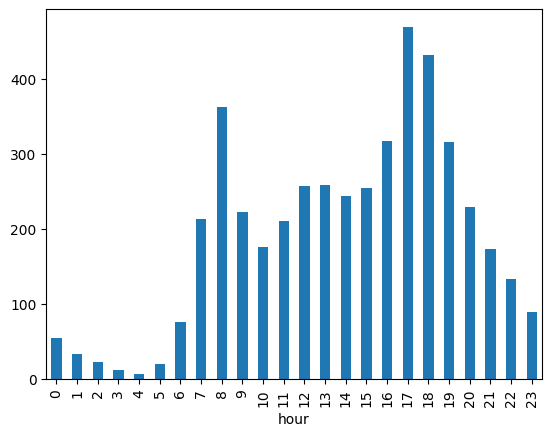

In [19]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot(kind= 'bar')


<AxesSubplot:title={'center':'Average hourly rent in Winter'}, xlabel='hour'>

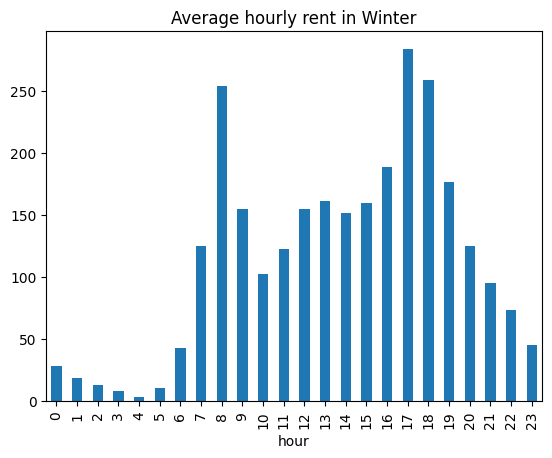

In [27]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
bikes[bikes['season']==1].groupby('hour').total.mean().plot(kind= 'bar'
                                                            , title = 'Average hourly rent in Winter')



De la gráfica podemos evidenciar una distribución bimodal con dos máximos locales a las 8:00 y las 17:00 horas. Evidentemente el intervalo entre las 22:00 y las 6:00 es el de menor número promedio de alquileres, nunca llegando a superar los 60 alquileres. Ninguna hora supera los 300 alquileres promedios.

<AxesSubplot:title={'center':'Average hourly rent in Summer'}, xlabel='hour'>

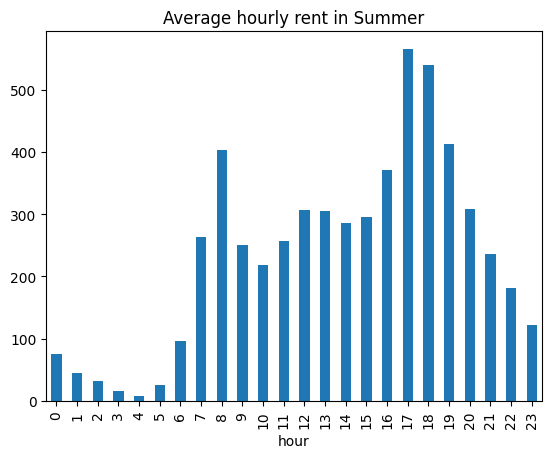

In [24]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
bikes[bikes['season']==3].groupby('hour').total.mean().plot(kind= 'bar', title = 'Average hourly rent in Summer')

De igual manera que en invierno, vemos una distribución bimodal con dos máximos locales a las 8:00 y las 17:00 horas. El intervalo entre las 7:00 y las 22:00 es el de mayor número de alquileres promedio. En invierno ninguna hora superó los 300 alquileres promedios. Mientras que en verano son varias las horas que superaron dicho valor. Se confirman las conclusiones del punto 1. Tanto que el volumen es superior en verano, como la existencia de horas pico.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [ ]:
# Celda 3


### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [ ]:
# Celda 4


### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [ ]:
# Celda 5


## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [ ]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

In [ ]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

In [ ]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [ ]:
# Celda 6


### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged donde:

-las primeras 100 muestras vienen de árboles de decisión donde max_depth tome un valor de su elección\
-las segundas 100 muestras vienen de árboles de decisión donde min_samples_leaf tome un valor de su elección\
-las últimas 100 muestras vienen de regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

Nota: 

Para este ensamble de 300 modelos, deben hacer votación mayoritaria. Esto lo pueden hacer de distintas maneras. La más "fácil" es haciendo la votación "manualmente", como se hace a partir del minuto 5:45 del video de Ejemplo práctico de emsablajes en Coursera. Digo que es la más fácil porque si hacen la votación mayoritaria sobre las 300 predicciones van a obtener lo que se espera.

Otra opción es: para cada uno de los 3 tipos de modelos, entrenar un ensamble de 100 modelos cada uno. Predecir para cada uno de esos tres ensambles y luego predecir como un ensamble de los 3 ensambles. La cuestión es que la votación mayoritaria al usar los 3 ensambles no necesariamente va a generar el mismo resultado que si hacen la votación mayoritaria directamente sobre los 300 modelos. Entonces, para los que quieran hacer esto, deben hacer ese último cálculo con cuidado.

Para los que quieran hacerlo como ensamble de ensambles, digo que se debe hacer el ensamble final con cuidado por lo siguiente. Supongamos que:

* para los 100 árboles del primer tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para los 100 árboles del segundo tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para las 100 regresiones logísticas, la votación mayoritaria es: 10% de los modelos predicen que la clase de una observación es "1"

Si se hace la votación mayoritaria de los 300 modelos, la predicción de esa observación debería ser: (100*55%+100*55%+100*10%)/300 = 40% de los modelos votan porque la predicción debería ser "1". Es decir, la predicción del ensamble es "0" (dado que menos del 50% de modelos predijo un 1).

Sin embargo, si miramos cada ensamble por separado, el primer ensamble predice "1", el segundo ensamble predice "1" y el último ensamble predice "0". Si hago votación mayoritaria sobre esto, la predicción va a ser "1", lo cual es distinto a si se hace la votación mayoritaria sobre los 300 modelos.

In [ ]:
# Celda 7


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [ ]:
# Celda 8


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

In [ ]:
# Celda 9